### loading Data 

In [1]:
import torch 
import numpy as np 
import sklearn as sk 
import pandas as pd 
import seaborn as sns 
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
# TO Tensor + Normalize + Flatten 
transform = transforms.Compose([transforms.ToTensor() ,
                                transforms.Normalize(mean=0 , std=1) , 
                                transforms.Lambda(lambda x: x.view(-1))])

import torch.nn.functional as F  
def collate_fn(batch):
    images, labels = zip(*batch)  
    images = torch.stack(images)  
    labels = torch.tensor(labels)  
    one_hot_labels = F.one_hot(labels, num_classes=10).float() 
    return images, one_hot_labels

Train_set = torchvision.datasets.FashionMNIST(root='./data' , train=True , download=True , transform=transform)
Test_set = torchvision.datasets.FashionMNIST(root='./data' , train=False , download=True , transform=transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(Train_set, batch_size=32, shuffle=True , collate_fn=collate_fn)
test_loader = DataLoader(Test_set, batch_size = 32 , shuffle=True , collate_fn=collate_fn)

In [3]:

data_iter = iter(test_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)
print("One-hot encoded label:" , labels[0])

data_iter = iter(train_loader)
images, labels = data_iter.__next__()
print("Transformed batch of images shape (flattened):", images.shape) 
print("One-hot encoded labels shape:", labels.shape)

Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])
One-hot encoded label: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Transformed batch of images shape (flattened): torch.Size([32, 784])
One-hot encoded labels shape: torch.Size([32, 10])


In [4]:
print("len of MLP input: "  , images.shape[1])
print("len of MLP output"  , labels.shape[1])

in_mlp =  images.shape[1]
out_mlp = labels.shape[1]

len of MLP input:  784
len of MLP output 10


## Defining the two models 

In [8]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

device = 'cpu' # apparently from previous question, Runs faster than MPS

In [12]:
# Model 1: 128 Hidden Layers

class MLP_1(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=128, output_size=out_mlp):
        super(MLP_1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)               
        self.fc2 = nn.Linear(hidden_size, output_size) 
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)      
        x = self.fc2(x)
        x = self.flatten(x)   
        return x


torch.random.manual_seed(42)
model_1 = MLP_1()
model_1.to(device=device)
loss_fnc_1 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)

summary(model_1 , images)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48

In [13]:
# Model 2: 48 Hidden Layers

class MLP_2(nn.Module):
    def __init__(self, input_size=in_mlp, hidden_size=48, output_size=out_mlp):
        super(MLP_2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)               
        self.fc2 = nn.Linear(hidden_size, output_size) 
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) 
        x = self.dropout(x)     
        x = self.fc2(x)
        x = self.flatten(x)   
        return x


torch.random.manual_seed(42)
model_2 = MLP_2()
model_2.to(device=device)
loss_fnc_2 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001 , weight_decay=0.0001)

summary(model_2 , images)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 48]                  37,680
├─Dropout: 1-2                           [-1, 48]                  --
├─Linear: 1-3                            [-1, 10]                  490
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.24


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 48]                  37,680
├─Dropout: 1-2                           [-1, 48]                  --
├─Linear: 1-3                            [-1, 10]                  490
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.24

In [14]:
def train_loop(model , num_epochs , optimizer , loss_fnc):  
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:

            optimizer.zero_grad() 

            outputs = model(inputs.to(device))

            loss = loss_fnc(outputs.cpu(), labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(outputs.cpu(), dim=1)
            act = torch.argmax(labels, dim=1)
            correct_train += ( pred == act).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train


        model.eval() 
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs.to(device))
                loss = loss_fnc(outputs.cpu(), labels)
            
                val_loss += loss.item()

                pred = torch.argmax(outputs.cpu(), dim=1)
                act = torch.argmax(labels, dim=1)

                correct_val += (pred == act).sum().item()
                total_val += labels.size(0)

        val_loss /= len(test_loader)
        val_acc = correct_val / total_val
                    

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_losses , val_losses , train_accuracies , val_accuracies

In [15]:
info_1 = train_loop(model_1 , 40 , optimizer_1 , loss_fnc_1)

Epoch [1/40], Train Loss: 0.5131, Val Loss: 0.4550, Train Acc: 0.8201, Val Acc: 0.8332
Epoch [2/40], Train Loss: 0.3809, Val Loss: 0.3821, Train Acc: 0.8624, Val Acc: 0.8628
Epoch [3/40], Train Loss: 0.3393, Val Loss: 0.3774, Train Acc: 0.8767, Val Acc: 0.8646
Epoch [4/40], Train Loss: 0.3172, Val Loss: 0.3526, Train Acc: 0.8829, Val Acc: 0.8740
Epoch [5/40], Train Loss: 0.2991, Val Loss: 0.3541, Train Acc: 0.8906, Val Acc: 0.8748
Epoch [6/40], Train Loss: 0.2819, Val Loss: 0.3613, Train Acc: 0.8973, Val Acc: 0.8729
Epoch [7/40], Train Loss: 0.2721, Val Loss: 0.3314, Train Acc: 0.8987, Val Acc: 0.8813
Epoch [8/40], Train Loss: 0.2595, Val Loss: 0.3528, Train Acc: 0.9049, Val Acc: 0.8767
Epoch [9/40], Train Loss: 0.2525, Val Loss: 0.3378, Train Acc: 0.9057, Val Acc: 0.8830
Epoch [10/40], Train Loss: 0.2401, Val Loss: 0.3344, Train Acc: 0.9101, Val Acc: 0.8842
Epoch [11/40], Train Loss: 0.2337, Val Loss: 0.3201, Train Acc: 0.9124, Val Acc: 0.8870
Epoch [12/40], Train Loss: 0.2242, Val Lo

In [16]:
info_2 = train_loop(model_2 , 40 , optimizer_2 , loss_fnc_2)

Epoch [1/40], Train Loss: 0.6275, Val Loss: 0.4800, Train Acc: 0.7828, Val Acc: 0.8294
Epoch [2/40], Train Loss: 0.4617, Val Loss: 0.4340, Train Acc: 0.8354, Val Acc: 0.8458
Epoch [3/40], Train Loss: 0.4281, Val Loss: 0.4260, Train Acc: 0.8469, Val Acc: 0.8468
Epoch [4/40], Train Loss: 0.4094, Val Loss: 0.4084, Train Acc: 0.8512, Val Acc: 0.8534
Epoch [5/40], Train Loss: 0.3951, Val Loss: 0.4013, Train Acc: 0.8569, Val Acc: 0.8535
Epoch [6/40], Train Loss: 0.3834, Val Loss: 0.3916, Train Acc: 0.8615, Val Acc: 0.8609
Epoch [7/40], Train Loss: 0.3760, Val Loss: 0.3792, Train Acc: 0.8634, Val Acc: 0.8608
Epoch [8/40], Train Loss: 0.3699, Val Loss: 0.3874, Train Acc: 0.8653, Val Acc: 0.8613
Epoch [9/40], Train Loss: 0.3626, Val Loss: 0.3946, Train Acc: 0.8678, Val Acc: 0.8538
Epoch [10/40], Train Loss: 0.3601, Val Loss: 0.3731, Train Acc: 0.8680, Val Acc: 0.8637
Epoch [11/40], Train Loss: 0.3560, Val Loss: 0.3704, Train Acc: 0.8712, Val Acc: 0.8674
Epoch [12/40], Train Loss: 0.3527, Val Lo

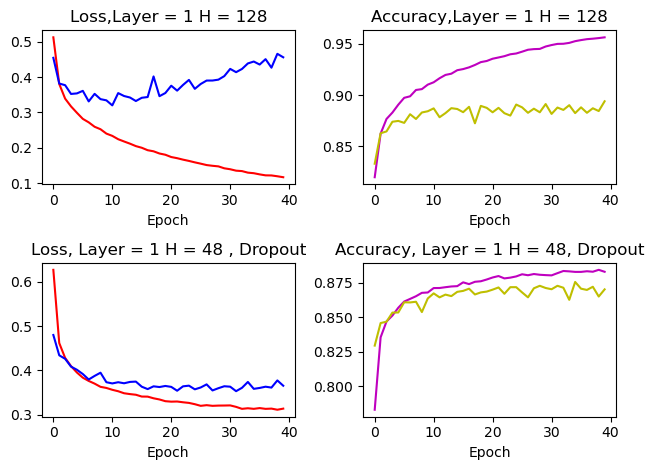

In [22]:

figure , ax = plt.subplots(2, 2)

ax[0,0].set_xlabel("Epoch")
ax[0 , 0].set_title("Loss,Layer = 1 H = 128")
ax[0 , 0].plot(info_1[0] , color = 'r' , label = "Train")
ax[0, 0].plot(info_1[1] , color = 'b' , label = "Test")

ax[0,1].set_xlabel("Epoch")
ax[0 , 1].set_title("Accuracy,Layer = 1 H = 128")
ax[0 , 1].plot(info_1[2] , color = 'm' , label = "Train")
ax[0 , 1].plot(info_1[3], color = 'y' , label = "Test")

ax[1,0].set_xlabel("Epoch")
ax[1 , 0].set_title("Loss, Layer = 1 H = 48 , Dropout")
ax[1 , 0].plot(info_2[0] , color = 'r' , label = "Train")
ax[1, 0].plot(info_2[1] , color = 'b' , label = "Test")

ax[1,1].set_xlabel("Epoch")
ax[1 , 1].set_title("Accuracy, Layer = 1 H = 48, Dropout")
ax[1 , 1].plot(info_2[2] , color = 'm' , label = "Train")
ax[1 , 1].plot(info_2[3], color = 'y' , label = "Test")

plt.tight_layout()

For Model = L == 1 , H == 128


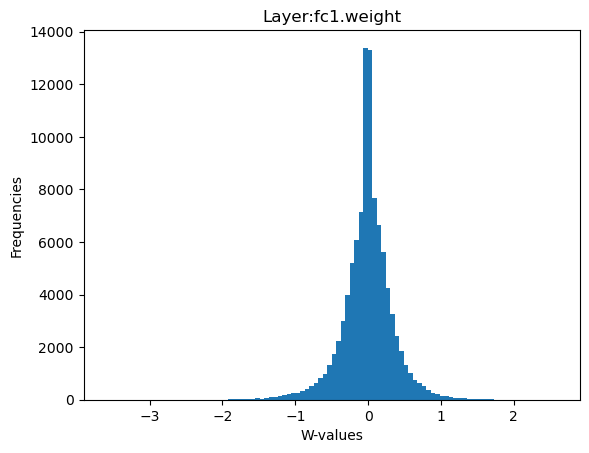

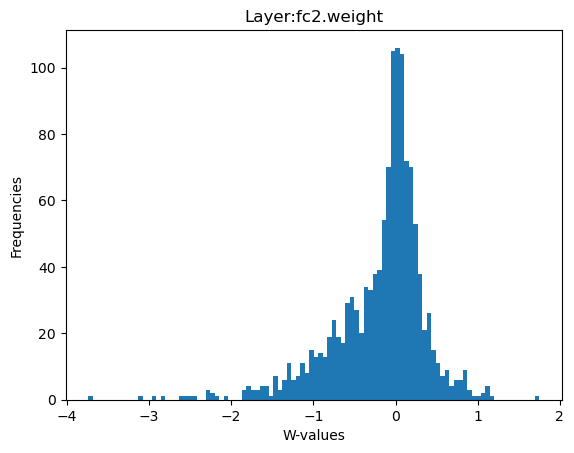

In [51]:
print("For Model = L == 1 , H == 128")
for name , para in model_1.named_parameters():
    if "weight" in name:
        plt.hist(para.detach().numpy().flatten() , bins=100)
        plt.title(f"Layer:{name}" )
        plt.xlabel("W-values")
        plt.ylabel("Frequencies")
        plt.show()


For Model = L == 1 , H == 48 , Dropout


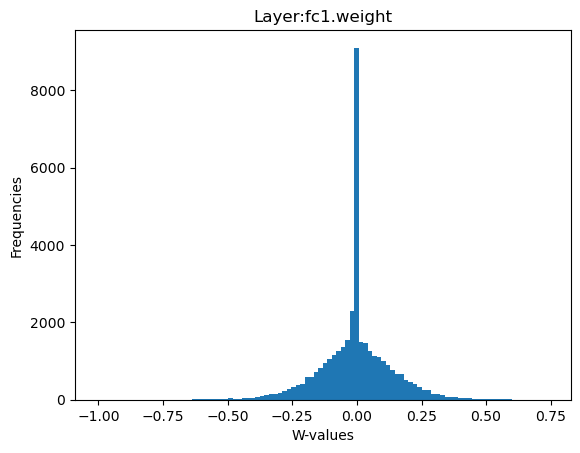

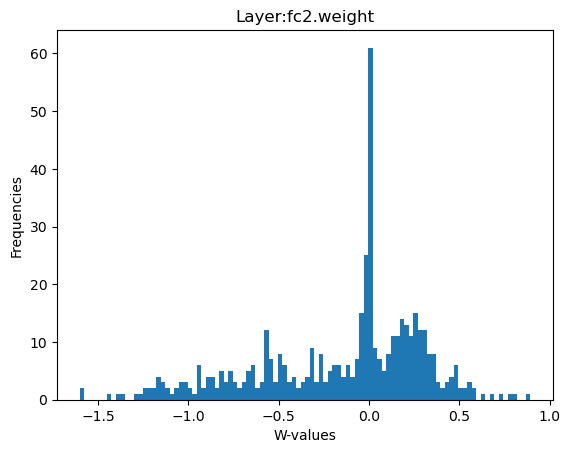

In [52]:
print("For Model = L == 1 , H == 48 , Dropout")
for name , para in model_2.named_parameters():
    if "weight" in name:
        plt.hist(para.detach().numpy().flatten() , bins=100)
        plt.title(f"Layer:{name}" )
        plt.xlabel("W-values")
        plt.ylabel("Frequencies")
        plt.show()

## used ADAM , Now Using SGD and RMSProp For model 1:

In [54]:
torch.random.manual_seed(42)
model_1 = MLP_1()
model_1.to(device=device)
loss_fnc_1 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_1 = optim.SGD(params=model_1.parameters() , lr = 0.001)

summary(model_1 , images)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48

In [55]:
info = train_loop(model_1 , 40 , optimizer_1 , loss_fnc_1)

Epoch [1/40], Train Loss: 1.8513, Val Loss: 1.4412, Train Acc: 0.5069, Val Acc: 0.6284
Epoch [2/40], Train Loss: 1.2027, Val Loss: 1.0500, Train Acc: 0.6563, Val Acc: 0.6545
Epoch [3/40], Train Loss: 0.9544, Val Loss: 0.8994, Train Acc: 0.6788, Val Acc: 0.6788
Epoch [4/40], Train Loss: 0.8436, Val Loss: 0.8211, Train Acc: 0.7031, Val Acc: 0.6982
Epoch [5/40], Train Loss: 0.7782, Val Loss: 0.7685, Train Acc: 0.7278, Val Acc: 0.7281
Epoch [6/40], Train Loss: 0.7319, Val Loss: 0.7298, Train Acc: 0.7491, Val Acc: 0.7445
Epoch [7/40], Train Loss: 0.6958, Val Loss: 0.6979, Train Acc: 0.7626, Val Acc: 0.7600
Epoch [8/40], Train Loss: 0.6663, Val Loss: 0.6716, Train Acc: 0.7762, Val Acc: 0.7686
Epoch [9/40], Train Loss: 0.6414, Val Loss: 0.6497, Train Acc: 0.7875, Val Acc: 0.7777
Epoch [10/40], Train Loss: 0.6203, Val Loss: 0.6307, Train Acc: 0.7939, Val Acc: 0.7832
Epoch [11/40], Train Loss: 0.6020, Val Loss: 0.6139, Train Acc: 0.8001, Val Acc: 0.7905
Epoch [12/40], Train Loss: 0.5863, Val Lo

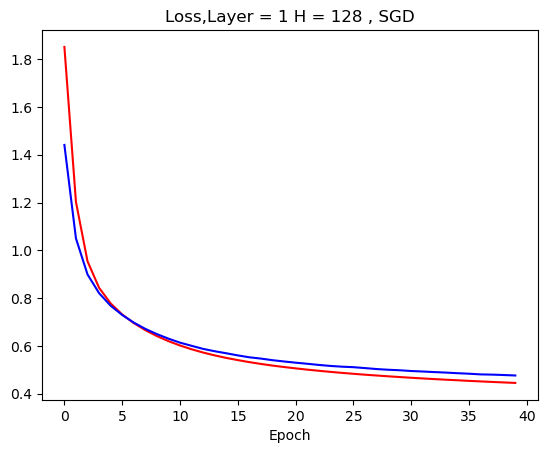

In [60]:
figure , ax = plt.subplots(1, 1)

plt.xlabel("Epoch")
plt.title("Loss,Layer = 1 H = 128 , SGD")
plt.plot(info[0] , color = 'r' , label = "Train")
plt.plot(info[1] , color = 'b' , label = "Test")
plt.show()

In [61]:
torch.random.manual_seed(42)
model_1 = MLP_1()
model_1.to(device=device)
loss_fnc_1 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_1 = optim.RMSprop(params=model_1.parameters() , lr = 0.001)

summary(model_1 , images)

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 128]                 100,480
├─Linear: 1-2                            [-1, 10]                  1,290
├─Flatten: 1-3                           [-1, 10]                  --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.48

In [62]:
info = train_loop(model_1 , 40 , optimizer_1 , loss_fnc_1)

Epoch [1/40], Train Loss: 0.4995, Val Loss: 0.4580, Train Acc: 0.8217, Val Acc: 0.8314
Epoch [2/40], Train Loss: 0.3739, Val Loss: 0.3783, Train Acc: 0.8655, Val Acc: 0.8643
Epoch [3/40], Train Loss: 0.3368, Val Loss: 0.3768, Train Acc: 0.8763, Val Acc: 0.8664
Epoch [4/40], Train Loss: 0.3126, Val Loss: 0.3647, Train Acc: 0.8859, Val Acc: 0.8669
Epoch [5/40], Train Loss: 0.2961, Val Loss: 0.3588, Train Acc: 0.8910, Val Acc: 0.8712
Epoch [6/40], Train Loss: 0.2830, Val Loss: 0.3514, Train Acc: 0.8956, Val Acc: 0.8747
Epoch [7/40], Train Loss: 0.2708, Val Loss: 0.3422, Train Acc: 0.8994, Val Acc: 0.8788
Epoch [8/40], Train Loss: 0.2611, Val Loss: 0.3453, Train Acc: 0.9040, Val Acc: 0.8757
Epoch [9/40], Train Loss: 0.2503, Val Loss: 0.3465, Train Acc: 0.9069, Val Acc: 0.8779
Epoch [10/40], Train Loss: 0.2446, Val Loss: 0.3733, Train Acc: 0.9083, Val Acc: 0.8794
Epoch [11/40], Train Loss: 0.2359, Val Loss: 0.3441, Train Acc: 0.9119, Val Acc: 0.8840
Epoch [12/40], Train Loss: 0.2296, Val Lo

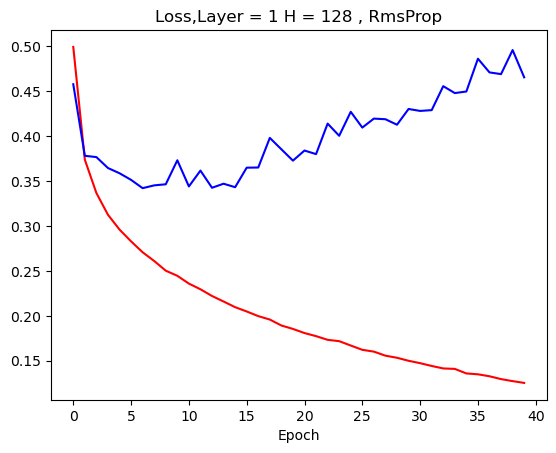

In [63]:

plt.xlabel("Epoch")
plt.title("Loss,Layer = 1 H = 128 , RmsProp")
plt.plot(info[0] , color = 'r' , label = "Train")
plt.plot(info[1] , color = 'b' , label = "Test")
plt.show()

## used ADAM , Now Using SGD and RMSProp For model 2:

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 48]                  37,680
├─Dropout: 1-2                           [-1, 48]                  --
├─Linear: 1-3                            [-1, 10]                  490
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.24
Epoch [1/40], Train Loss: 1.9475, Val Loss: 1.5842, Train Acc: 0.3992, Val Acc: 0.6102
Epoch [2/40], Train Loss: 1.3877, Val Loss: 1.1696, Train Acc: 0.5694, Val Acc: 0.6499
Epoch [3/40], Train Loss: 1.1185, Val Loss: 0.9827, Train Acc: 0.6228, Val Acc: 0.6719
Epoch [4/40], Train Loss: 0.9893, Val Loss: 0.8855, Train Acc: 0.6547, Val Acc: 0.6916
Epoch [5/40], Train Loss: 0.9096, Val Loss: 0.8248, Train Acc: 0.6793, Val Acc: 0

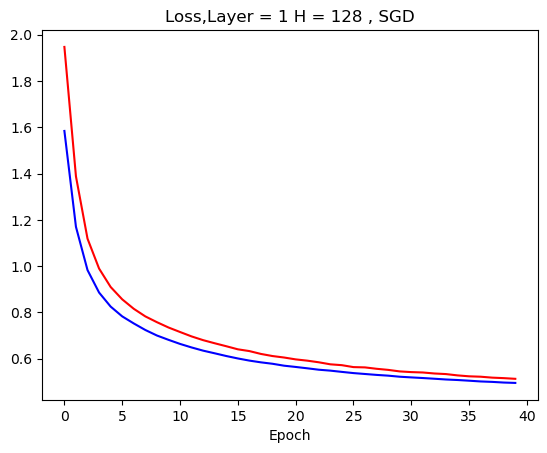

In [65]:
torch.random.manual_seed(42)
model_2 = MLP_2()
model_2.to(device=device)
loss_fnc_2 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_2 = optim.SGD(params=model_2.parameters() , lr = 0.001 , weight_decay=0.0001)

summary(model_2 , images)


info = train_loop(model_2 , 40 , optimizer_2 , loss_fnc_2)

plt.xlabel("Epoch")
plt.title("Loss,Layer = 1 H = 128 , SGD")
plt.plot(info[0] , color = 'r' , label = "Train")
plt.plot(info[1] , color = 'b' , label = "Test")
plt.show()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 48]                  37,680
├─Dropout: 1-2                           [-1, 48]                  --
├─Linear: 1-3                            [-1, 10]                  490
├─Flatten: 1-4                           [-1, 10]                  --
Total params: 38,170
Trainable params: 38,170
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.24
Epoch [1/40], Train Loss: 0.6393, Val Loss: 0.4957, Train Acc: 0.7763, Val Acc: 0.8194
Epoch [2/40], Train Loss: 0.4787, Val Loss: 0.4438, Train Acc: 0.8305, Val Acc: 0.8402
Epoch [3/40], Train Loss: 0.4352, Val Loss: 0.4129, Train Acc: 0.8441, Val Acc: 0.8501
Epoch [4/40], Train Loss: 0.4118, Val Loss: 0.4020, Train Acc: 0.8501, Val Acc: 0.8539
Epoch [5/40], Train Loss: 0.3954, Val Loss: 0.3954, Train Acc: 0.8580, Val Acc: 0

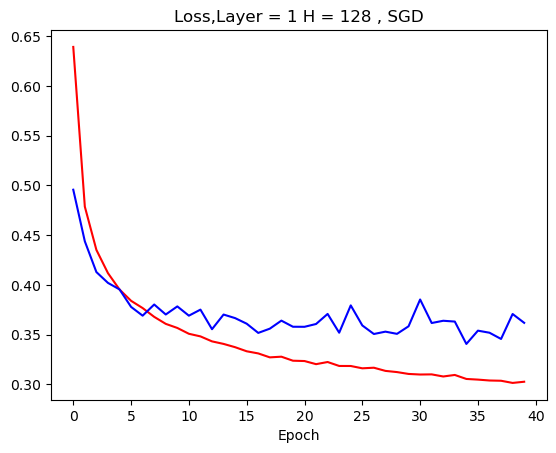

In [66]:
torch.random.manual_seed(42)
model_2 = MLP_2()
model_2.to(device=device)
loss_fnc_2 = nn.CrossEntropyLoss() # Negative Log-Likelihood Loss
optimizer_2 = optim.RMSprop(params=model_2.parameters() , lr = 0.001 , weight_decay=0.0001)

summary(model_2 , images)


info = train_loop(model_2 , 40 , optimizer_2 , loss_fnc_2)

plt.xlabel("Epoch")
plt.title("Loss,Layer = 1 H = 128 , SGD")
plt.plot(info[0] , color = 'r' , label = "Train")
plt.plot(info[1] , color = 'b' , label = "Test")
plt.show()